## 1.1 Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## 1.2 Import data

In [2]:
df = pd.read_csv('AirPassengers.csv',
                 parse_dates=['Month'],
                 date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m'),
                 index_col='Month')
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [4]:
ts = df['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

## 1.3 Explore data

In [5]:
ts['1949-01-01'] # or ts[datetime.datetime(1949,1,1)]

112

In [6]:
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [7]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

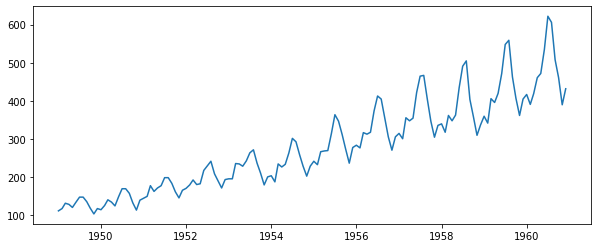

In [8]:
pd.plotting.register_matplotlib_converters()

plt.figure(figsize=(10,4))
plt.plot(ts)

## 1.4 Checking stationarity

A time series is said to be stationary if its statistical properties such as mean & variance remain constant over time. It does not mean that the series does not change over time, but the *way* it changes remains constant.

![](https://i.imgur.com/AD6qwo4.png)

Most of the time series models work on the assumption the time series is stationary so we need to make sure the TS is in stationary format (or close to).

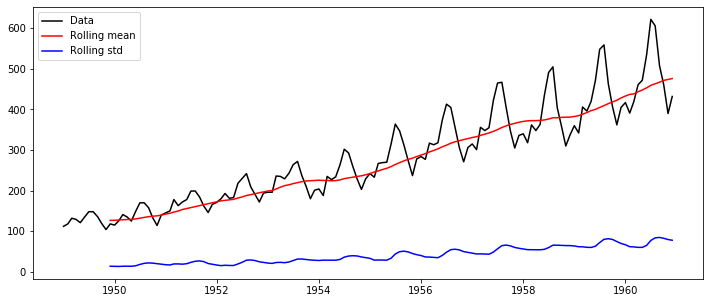

Test Statistic           0.815369
p-value                  0.991880
# Lags used             13.000000
# Observations used    130.000000
Critical Value 1%       -3.481682
Critical Value 5%       -2.884042
Critical Value 10%      -2.578770
dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):

    # Rolling statistics 1 year at a time
    rolmean = ts.rolling(window=12).mean()
    rolstd  = ts.rolling(window=12).std()

    # Plot rolling stats
    plt.figure(figsize=(12,5))
    plt.plot(ts, color='black', label='Data')
    plt.plot(rolmean, color='red', label='Rolling mean')
    plt.plot(rolstd, color='blue', label='Rolling std')
    plt.legend()
    plt.show(block=False)

    # Display Dickey-Fuller test
    test = adfuller(ts, autolag='AIC')

    df_test = pd.Series(
        data=[*test[0:4], *test[4].values()],
        index=[
            'Test Statistic',
            'p-value',
            '# Lags used',
            '# Observations used',
            *['Critical Value {:s}'.format(x) for x in test[4].keys()]
        ])
    print(df_test)

test_stationarity(ts)

Here the p-value is 0.99, which clearly indicates that the data is not stationary. We can also see it on the graph.

## 2.1 Rescale data

When data are very strongly skewed (ie much of the data is clustered around a value), then it can be difficult to see patterns in the data besides the peak. A transformation is a rescaling of the data using a function — here we'll use the logarithm (base 10). This makes any potential outliers appear much less extreme than in the original data set and expose hidden patterns. It'll make our data easier to model and the predictions more accurate.

Original data: Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

Rescaled data: Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64


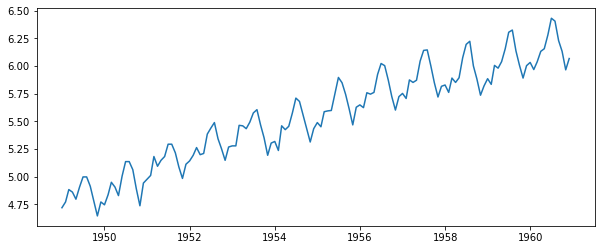

In [10]:
ts_log = np.log(ts)

print('Original data:', ts.head())
print('\nRescaled data:', ts_log.head())

plt.figure(figsize=(10,4))
plt.plot(ts_log)

## 2.3 Identify trends & seasonality

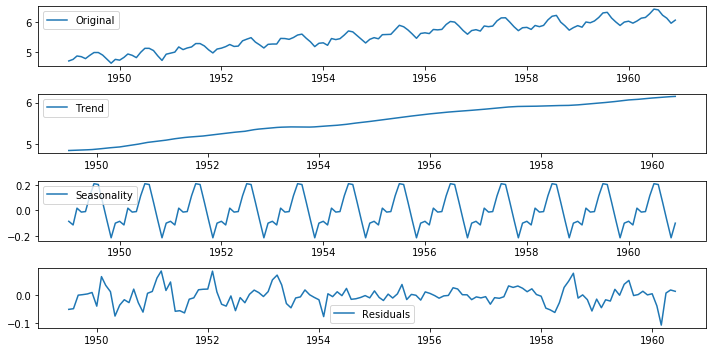

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend()

trend = decomposition.trend
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()

seasonal = decomposition.seasonal
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend()

residual = decomposition.resid
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend()
plt.tight_layout()

## 3.1 Make the data stationary

### Smoothing with Moving average

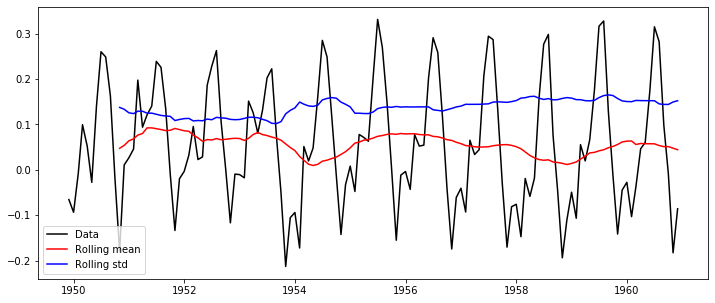

Test Statistic          -3.162908
p-value                  0.022235
# Lags used             13.000000
# Observations used    119.000000
Critical Value 1%       -3.486535
Critical Value 5%       -2.886151
Critical Value 10%      -2.579896
dtype: float64


In [12]:
moving_avg      = ts_log.rolling(window=12).mean()
smoothed_ts_log = (ts_log - moving_avg).dropna()

test_stationarity(smoothed_ts_log)

### Smoothing with Exponentially Weighted Moving Average

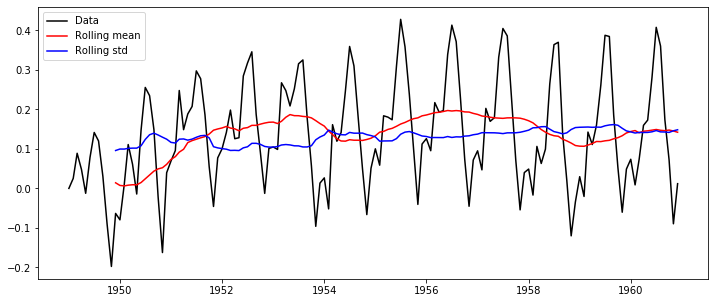

Test Statistic          -3.601262
p-value                  0.005737
# Lags used             13.000000
# Observations used    130.000000
Critical Value 1%       -3.481682
Critical Value 5%       -2.884042
Critical Value 10%      -2.578770
dtype: float64


In [13]:
w_moving_avg    = ts_log.ewm(halflife=12).mean()
smoothed_ts_log = (ts_log - w_moving_avg)

test_stationarity(smoothed_ts_log)

### Smooting with the next month

Taking the difference between each month and the next

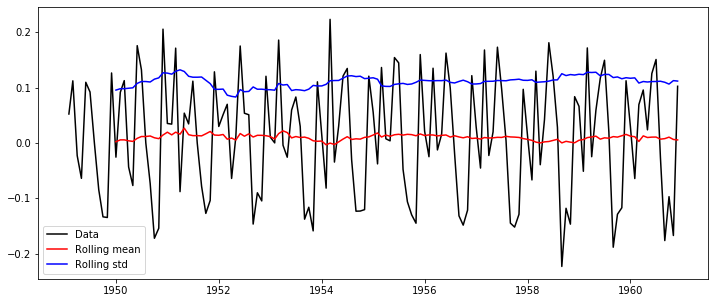

Test Statistic          -2.717131
p-value                  0.071121
# Lags used             14.000000
# Observations used    128.000000
Critical Value 1%       -3.482501
Critical Value 5%       -2.884398
Critical Value 10%      -2.578960
dtype: float64


In [14]:
test_stationarity((ts_log - ts_log.shift()).dropna())

The mean and variance are quite smooth so we will use this method.

In [15]:
ts_log_smoothed = (ts_log - ts_log.shift()).dropna()

## 3.2 Check correlation factor

Check the auto-correlation factor (ACF)
and partial auto-correlation factor (PACF).

In [16]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf  = acf(ts_log_smoothed, nlags=20, fft=False)
lag_pacf = pacf(ts_log_smoothed, nlags=20, method='ols')

Text(0.5, 1.0, 'Partial Auto-Correlation Factor (PACF)')

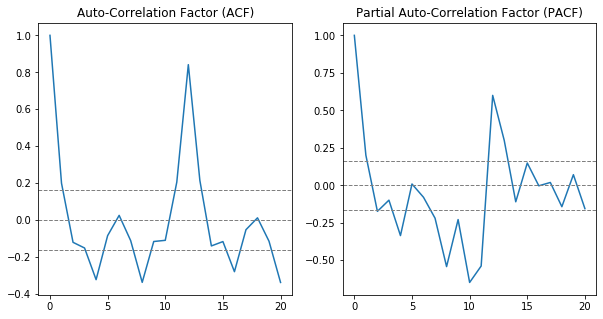

In [17]:
n = len(ts_log_smoothed)
discreet = {
    'lines.linestyle': 'dashed',
    'lines.color'    : 'gray',
    'lines.linewidth': 1}

# Plot ACF
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(lag_acf)

with plt.rc_context(discreet):
    plt.axhline(y=0)
    plt.axhline(y=-1.96/np.sqrt(n))
    plt.axhline(y=1.96/np.sqrt(n))

plt.title('Auto-Correlation Factor (ACF)')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)

with plt.rc_context(discreet):
    plt.axhline(y=0)
    plt.axhline(y=-1.96/np.sqrt(n))
    plt.axhline(y=1.96/np.sqrt(n))

plt.title('Partial Auto-Correlation Factor (PACF)')

Correlation of 0 or within the boundaries (+/- 1.96): no correlation.  
If the data doesn't have any correlation, we can't use it.

Here, we can see a correlation pattern on both ACF and PACF.

* Good ACF : Auto Regressive (AR) Integrated (I) Moving Average (MA)
* Good PACF: Moving Average
* Good ACF & PACF: we can use either model.  
  We will use ARIMA, which tends to give better results

## 3.3 Build time series model

In an ARIMA model, there are 3 parameters that are used to help model the major aspects of a time series: seasonality, trend and noise. These parameters are labeled p, d and q.

* p: number of auto-regressive terms  
  p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values — ie lags of dependent variable. If p is 5, the predictors for x(t) will be x(t-1)....x(t-5)<br><br>

* d: number of differences  
  d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series<br><br>
  
* q: number of moving average terms  
  q is size of the moving average part window of the model — ie lagged forecast errors in prediction equation. If q is 5, the predictors for x(t) will be e(t-1)...e(t-5) where e(i) is the difference between the moving average at ith instand and actual value.

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
from statsmodels.tsa.arima_model import ARIMA

def build_model(order):
    model = ARIMA(ts_log, order=order)
    res   = model.fit(disp=-1)

    plt.figure(figsize=(10,4))
    plt.plot(ts_log_smoothed, color='lightgray', linewidth=1)
    plt.plot(res.fittedvalues, color='blue')

    rss = sum(res.fittedvalues - ts_log_smoothed)**2
    plt.title('RSS: {:.4f}'.format(rss))

    return res

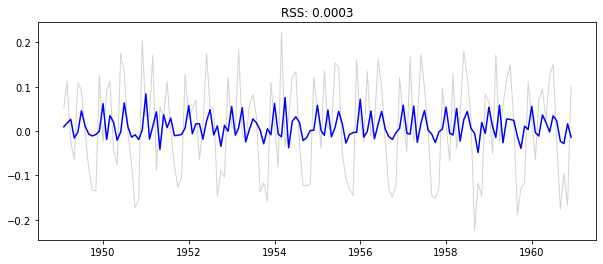

In [20]:
# 2: auto-regressive, 1: integrated, 0: moving average
arima = build_model((2,1,0))

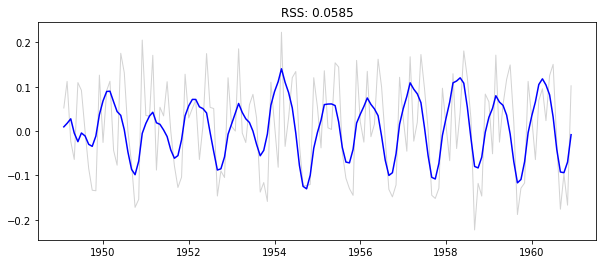

In [21]:
arima = build_model((2,1,2))

ARIMA is doing better at learning the pattern of the data with these parameters.  
We will use this model for predictions.

## 3.4 Convert back to original scale

In [22]:
df_arima = pd.Series(arima.fittedvalues)
df_arima.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [23]:
df_arima_cumsum = df_arima.cumsum()
df_arima_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [24]:
df_arima_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
df_arima_log = df_arima_log.add(df_arima_cumsum, fill_value=0)
df_arima_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

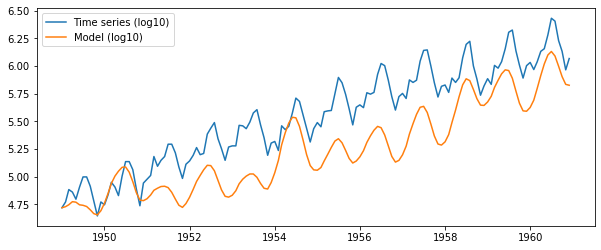

In [25]:
plt.figure(figsize=(10,4))
plt.plot(ts_log, label='Time series (log10)')
plt.plot(df_arima_log, label='Model (log10)')
plt.legend()

## 3.5 Predict future trends

In [26]:
len(ts)

144

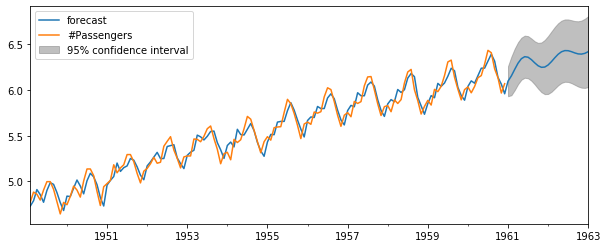

In [27]:
# Predict the next 24 months
fig = arima.plot_predict(1,144 + 24)
fig.set_figwidth(10)

In [28]:
forecast, stderr, conf_int = arima.forecast(steps=24)

pd.DataFrame(
    data=[forecast, stderr, conf_int],
    index=['Forecast', 'Standard error', 'Confidence interval']
).T

,Forecast,Standard error,Confidence interval
0,6.09553,0.0838471,"[5.931196678502998, 6.2598713225946]"
1,6.15281,0.107495,"[5.942128575138849, 6.363499759320893]"
2,6.22443,0.115687,"[5.997687563119572, 6.451172081586745]"
3,6.29241,0.117028,"[6.063040977985321, 6.521781340999069]"
4,6.34165,0.117035,"[6.112262927677815, 6.5710315801192785]"
5,6.36359,0.11744,"[6.133415094922603, 6.5937721554682645]"
6,6.35785,0.117623,"[6.127310897048173, 6.588382662234555]"
7,6.33139,0.117787,"[6.100534343395868, 6.562251452891303]"
8,6.29598,0.120242,"[6.060305971884307, 6.531644482732877]"
9,6.26448,0.12736,"[6.014855155370242, 6.514098793371076]"
